In [5]:
# Cell 1: Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
import tensorflow as tf
from imblearn.over_sampling import SMOTE
import joblib

%matplotlib inline

In [6]:
# Cell 2: Define the CustomerProminencePredictor class
class CustomerProminencePredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.income_le = LabelEncoder()
        self.policy_le = LabelEncoder()
        self.model = None
        self.all_columns = None
        self.cltv_median = None
        
    def load_and_preprocess(self, data_path, is_train=True):
        """Load and preprocess data with visualization"""
        print("\n=== Loading and Preprocessing Data ===")
        data = pd.read_csv(data_path)
        
        if is_train:
            # Target variable creation (only for training)
            self.cltv_median = data['cltv'].median()
            data['Prominence'] = (data['cltv'] >= self.cltv_median).astype(int)
            
            # Visualize target
            plt.figure(figsize=(8,5))
            sns.countplot(x='Prominence', data=data)
            plt.title('Prominence Distribution (0=Below Median, 1=Above Median)')
            plt.show()
        
        # Label Encoding
        if is_train:
            data['income'] = self.income_le.fit_transform(data['income'])
            data['num_policies'] = self.policy_le.fit_transform(data['num_policies'])
            joblib.dump(self.income_le, 'income_encoder.save')
            joblib.dump(self.policy_le, 'policy_encoder.save')
        else:
            data['income'] = self.income_le.transform(data['income'])
            data['num_policies'] = self.policy_le.transform(data['num_policies'])
            
        data['type_of_policy'] = data['type_of_policy'].map({'Silver':0, 'Gold':1, 'Platinum':2})
        
        # One-hot encoding
        categorical_cols = ['gender', 'area', 'qualification', 'policy']
        for col in categorical_cols:
            data[col] = data[col].astype(str)
        data = pd.get_dummies(data, columns=categorical_cols)
        
        if is_train:
            self.all_columns = data.columns
            X = data.drop(['Prominence', 'id', 'cltv'], axis=1)
            y = data['Prominence']
            return X, y
        else:
            # Ensure same columns as training
            for col in self.all_columns:
                if col not in data.columns and col not in ['Prominence', 'id', 'cltv']:
                    data[col] = 0
            return data[[col for col in self.all_columns if col not in ['Prominence', 'id', 'cltv']]]
    
    def train_model(self, X_train, y_train, X_val, y_val):
        """Train improved neural network model with better architecture"""
        # Handle class imbalance
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        
        # Create feature interactions
        X_train_res = self.create_interactions(X_train_res)
        X_val = self.create_interactions(X_val)
        
        # Scale features
        X_train_scaled = self.scaler.fit_transform(X_train_res)
        X_val_scaled = self.scaler.transform(X_val)
        joblib.dump(self.scaler, 'scaler.save')
        
        # Build IMPROVED model
        self.model = Sequential([
            Input(shape=(X_train_scaled.shape[1],)),
            Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            Dropout(0.4),
            BatchNormalization(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            BatchNormalization(),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        # Custom optimizer configuration
        optimizer = Adam(learning_rate=0.0005)
        
        # Enhanced model compilation
        self.model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', 
                    metrics.AUC(name='roc_auc'),
                    metrics.Precision(name='precision'),
                    metrics.Recall(name='recall')]
        )
        
        # Configure callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_roc_auc',  # Now monitoring AUC
                patience=15,
                mode='max',
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-6
            )
        ]
        
        # Train model with increased epochs
        history = self.model.fit(
            X_train_scaled, y_train_res,
            validation_data=(X_val_scaled, y_val),
            epochs=50,
            batch_size=128,
            callbacks=callbacks,
            verbose=1
        )
        
        return history

    # Add this new method to your class
    def create_interactions(self, df):
        """Create new interaction features"""
        if 'claim_amount' in df.columns and 'income' in df.columns:
            df['claim_income_ratio'] = df['claim_amount'] / (df['income'] + 1)
        if 'type_of_policy' in df.columns and 'vintage' in df.columns:
            df['policy_vintage'] = df['type_of_policy'] * df['vintage']
        return df
        
        # Plot training history
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.legend()
        
        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.legend()
        plt.show()
        
        return history
    
    def evaluate_model(self, X_val, y_val):
        """Evaluate model performance"""
        X_val_scaled = self.scaler.transform(X_val)
        y_pred = (self.model.predict(X_val_scaled) > 0.5).astype(int)
        
        print(classification_report(y_val, y_pred))
        print(f"ROC AUC: {roc_auc_score(y_val, self.model.predict(X_val_scaled)):.4f}")
        
        # Confusion matrix
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Prominent', 'Prominent'],
                   yticklabels=['Not Prominent', 'Prominent'])
        plt.title('Confusion Matrix')
        plt.show()
    
    def predict_new_data(self, test_path):
        """Make predictions on new test data"""
        test_data = self.load_and_preprocess(test_path, is_train=False)
        test_data_scaled = self.scaler.transform(test_data)
        return (self.model.predict(test_data_scaled) > 0.5).astype(int)


=== Loading and Preprocessing Data ===


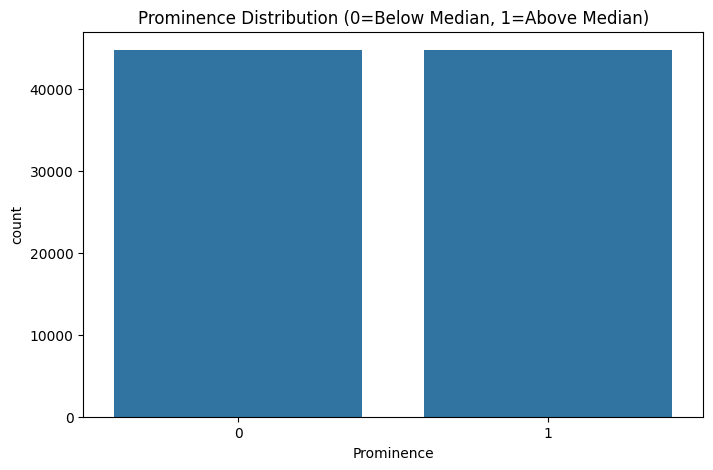

In [7]:
# Cell 3: Initialize predictor and load training data
predictor = CustomerProminencePredictor()
X, y = predictor.load_and_preprocess('train_BRCpofr.csv')

In [8]:
# Cell 4: Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}")

Training set: (62574, 16), Validation set: (26818, 16)


In [9]:
from tensorflow.keras.layers import BatchNormalization
# OR
from keras.layers import BatchNormalization

In [10]:
# Cell 5: Train the model
history = predictor.train_model(X_train, y_train, X_val, y_val)

Epoch 1/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6580 - loss: 0.8988 - precision: 0.6271 - recall: 0.7918 - roc_auc: 0.6959 - val_accuracy: 0.7421 - val_loss: 0.6687 - val_precision: 0.6801 - val_recall: 0.9146 - val_roc_auc: 0.7665 - learning_rate: 5.0000e-04
Epoch 2/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7317 - loss: 0.6674 - precision: 0.6784 - recall: 0.8749 - roc_auc: 0.7541 - val_accuracy: 0.7420 - val_loss: 0.5954 - val_precision: 0.6797 - val_recall: 0.9159 - val_roc_auc: 0.7649 - learning_rate: 5.0000e-04
Epoch 3/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7402 - loss: 0.5943 - precision: 0.6860 - recall: 0.8919 - roc_auc: 0.7640 - val_accuracy: 0.7423 - val_loss: 0.5656 - val_precision: 0.6798 - val_recall: 0.9166 - val_roc_auc: 0.7692 - learning_rate: 5.0000e-04
Epoch 4/50
490/490 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7398 - loss: 0.5703 - precision: 0.6819 - recall: 0.9005 - roc_auc: 0.7633 - val_accuracy: 0.7429 - 

839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.88      0.57      0.69     13403
           1       0.68      0.92      0.78     13415

    accuracy                           0.74     26818
   macro avg       0.78      0.74      0.73     26818
weighted avg       0.78      0.74      0.73     26818

839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
ROC AUC: 0.7739


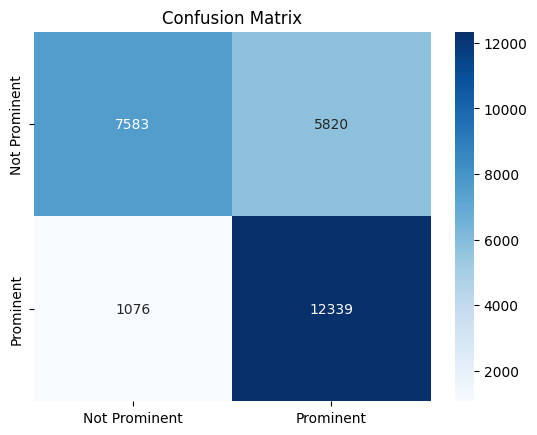

In [11]:
# Cell 6: Evaluate model performance
predictor.evaluate_model(X_val, y_val)

In [12]:
# Cell 7: Save the trained model
predictor.model.save('prominence_model.h5')
print("Model saved as 'prominence_model.h5'")

Model saved as 'prominence_model.h5'


In [13]:
# Cell 8: Prepare test data and make predictions
# First check required columns
required_columns = [col for col in predictor.all_columns if col not in ['Prominence', 'id', 'cltv']]
print("Required columns for test data:")
print(required_columns)

# Load and check test data
test_data = pd.read_csv('test_koRSKBP.csv')
print("\nTest data columns:")
print(test_data.columns.tolist())

# Make predictions
try:
    predictions = predictor.predict_new_data('test_koRSKBP.csv')
    test_data['Prominence_Prediction'] = predictions
    test_data.to_csv('test_predictions.csv', index=False)
    print("\nPredictions saved successfully!")
    print(f"Prominent customers: {predictions.sum()}/{len(predictions)}")
    
except Exception as e:
    print(f"\nError: {str(e)}")
    print("Common issues:")
    print("1. Missing required columns")
    print("2. New categorical values not seen in training")
    print("3. Null values in features")

Required columns for test data:
['income', 'marital_status', 'vintage', 'claim_amount', 'num_policies', 'type_of_policy', 'gender_Female', 'gender_Male', 'area_Rural', 'area_Urban', 'qualification_Bachelor', 'qualification_High School', 'qualification_Others', 'policy_A', 'policy_B', 'policy_C']

Test data columns:
['id', 'gender', 'area', 'qualification', 'income', 'marital_status', 'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy']

=== Loading and Preprocessing Data ===

Error: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- claim_income_ratio
- policy_vintage

Common issues:
1. Missing required columns
2. New categorical values not seen in training
3. Null values in features


839/839 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model Accuracy: 0.7429
Precision: 0.6795
Recall: 0.9198
F1 Score: 0.7816
ROC AUC: 0.7739

Classification Report:
              precision    recall  f1-score       support
0              0.875736  0.565769  0.687426  13403.000000
1              0.679498  0.919791  0.781592  13415.000000
accuracy       0.742859  0.742859  0.742859      0.742859
macro avg      0.777617  0.742780  0.734509  26818.000000
weighted avg   0.777573  0.742859  0.734530  26818.000000


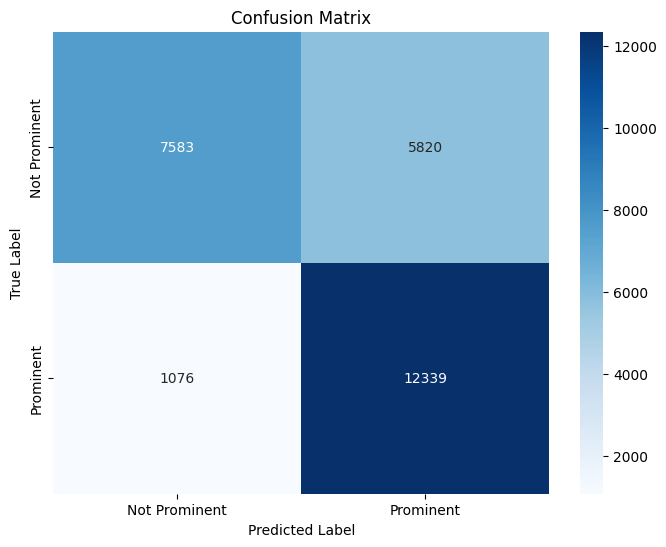

In [14]:
# First import all required libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def calculate_model_accuracy(predictor, X_val, y_val):
    """
    Calculate and return the accuracy metrics for the trained model
    
    Args:
        predictor: Trained CustomerProminencePredictor instance
        X_val: Validation features
        y_val: Validation labels
        
    Returns:
        dict: Dictionary containing various accuracy metrics
    """
    # Scale the validation data
    X_val_scaled = predictor.scaler.transform(X_val)
    
    # Get predicted probabilities and binary predictions
    y_pred_proba = predictor.model.predict(X_val_scaled)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    
    # Classification report
    clf_report = classification_report(y_val, y_pred, output_dict=True)
    
    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    
    # Create a dictionary with all metrics
    metrics_dict = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'classification_report': clf_report,
        'confusion_matrix': cm.tolist()  # Convert numpy array to list for better serialization
    }
    
    return metrics_dict

# Usage example (make sure you have these variables defined from your previous code):
# predictor = CustomerProminencePredictor()
# history = predictor.train_model(X_train, y_train, X_val, y_val)
if 'predictor' in globals() and 'X_val' in globals() and 'y_val' in globals():
    accuracy_metrics = calculate_model_accuracy(predictor, X_val, y_val)

    # Print the metrics
    print(f"Model Accuracy: {accuracy_metrics['accuracy']:.4f}")
    print(f"Precision: {accuracy_metrics['precision']:.4f}")
    print(f"Recall: {accuracy_metrics['recall']:.4f}")
    print(f"F1 Score: {accuracy_metrics['f1_score']:.4f}")
    print(f"ROC AUC: {accuracy_metrics['roc_auc']:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(pd.DataFrame(accuracy_metrics['classification_report']).transpose())

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(accuracy_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Prominent', 'Prominent'],
                yticklabels=['Not Prominent', 'Prominent'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
else:
    print("Required variables (predictor, X_val, y_val) not found. Please run your training code first.")

In [15]:
import pandas as pd
import joblib
from tensorflow.keras.models import load_model

class CustomerProminencePredictor:
    def __init__(self):
        # Load all preprocessing artifacts
        self.scaler = joblib.load('scaler.save')
        self.income_le = joblib.load('income_encoder.save')
        self.policy_le = joblib.load('policy_encoder.save')
        self.model = load_model('prominence_model.h5')
        self.all_columns = joblib.load('training_columns.save')  # Load saved columns
        
        # Get categorical mappings from training
        self.income_categories = self.income_le.classes_
        self.policy_categories = self.policy_le.classes_

    def preprocess_input(self, input_data):
        """Preprocess user input with proper categorical handling"""
        # Convert to DataFrame
        input_df = pd.DataFrame([input_data])
        
        # Convert marital status
        input_df['marital_status'] = input_df['marital_status'].map({'Single': 0, 'Married': 1})
        
        # Label encode known categories
        input_df['income'] = self.income_le.transform(input_df['income'])
        input_df['num_policies'] = self.policy_le.transform(input_df['num_policies'])
        
        # Map policy type
        policy_map = {'Silver':0, 'Gold':1, 'Platinum':2}
        input_df['type_of_policy'] = input_df['type_of_policy'].map(policy_map)
        
        # One-hot encode categoricals
        categorical_cols = ['gender', 'area', 'qualification', 'policy']
        for col in categorical_cols:
            input_df[col] = input_df[col].astype(str)
        
        input_df = pd.get_dummies(input_df, columns=categorical_cols)
        
        # Add missing columns from training
        for col in self.all_columns:
            if col not in input_df.columns:
                input_df[col] = 0
                
        # Create interaction features
        input_df['claim_income_ratio'] = input_df['claim_amount'] / (input_df['income'] + 1)
        input_df['policy_vintage'] = input_df['type_of_policy'] * input_df['vintage']
        
        # Ensure correct column order
        input_df = input_df[self.all_columns]
        
        # Scale features
        return self.scaler.transform(input_df)

def get_user_input():
    """Collect user input with validation"""
    print("\nPlease enter customer details:")
    
    return {
        'gender': validate_input("Gender", ["Male", "Female"]),
        'area': validate_input("Area", ["Urban", "Rural"]),
        'qualification': validate_input("Qualification", ["Bachelor", "High School", "Others"]),
        'income': validate_input("Income", ["<2L", "2-5L", "5_10L", "more than 10L"]),
        'marital_status': validate_input("Marital Status", ["Single", "Married"]),
        'vintage': get_number("Vintage (customer relationship duration in days): ", int),
        'claim_amount': get_number("Claim amount: ", float),
        'num_policies': validate_input("Number of policies", ["1", "more than 1"]),
        'policy': validate_input("Policy", ["A", "B", "C"]),
        'type_of_policy': validate_input("Type of policy", ["Silver", "Gold", "Platinum"])
    }

def validate_input(field_name, allowed_values):
    """Validate categorical inputs"""
    while True:
        value = input(f"{field_name} ({'/'.join(allowed_values)}): ").strip().capitalize()
        if value in allowed_values:
            return value
        print(f"Invalid {field_name.lower()}! Please choose from {allowed_values}")

def get_number(prompt, dtype):
    """Validate numerical inputs"""
    while True:
        try:
            return dtype(input(prompt))
        except ValueError:
            print("Please enter a valid number")

def predict_prominence():
    """Main prediction function"""
    predictor = CustomerProminencePredictor()
    
    try:
        user_input = get_user_input()
        processed_input = predictor.preprocess_input(user_input)
        prediction = predictor.model.predict(processed_input)[0][0]
        
        # Format results
        is_prominent = prediction >= 0.5
        confidence = prediction if is_prominent else 1 - prediction
        status = "Prominent" if is_prominent else "Not Prominent"
        
        print("\n=== Prediction Results ===")
        print(f"Customer Status: {status}")
        print(f"Confidence Level: {confidence:.2%}")
        print(f"Raw Probability: {prediction:.4f}")
        
    except Exception as e:
        print(f"\nError: {str(e)}")
        print("Common issues:")
        print("- Unexpected categorical values")
        print("- Missing required fields")
        print("- Invalid numerical values")

if __name__ == "__main__":
    predict_prominence()


Please enter customer details:
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '2-5L', '5_10L', 'more than 10L']
Invalid income! Please choose from ['<2L', '

KeyboardInterrupt: Interrupted by user

In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model
import joblib

class CustomerProminencePredictor:
    def __init__(self):
        self.scaler = joblib.load('scaler.save')
        self.income_le = joblib.load('income_encoder.save')
        self.policy_le = joblib.load('policy_encoder.save')
        self.model = load_model('prominence_model.h5')
        self.all_columns = joblib.load('training_columns.save')
        
    def preprocess_input(self, input_data):
        """Preprocess user input to match training format"""
        # Convert input to DataFrame
        data = pd.DataFrame([input_data])
        
        # Convert policy type
        policy_map = {'Silver':0, 'Gold':1, 'Platinum':2}
        data['type_of_policy'] = data['type_of_policy'].map(policy_map)
        
        # Label encoding
        data['income'] = self.income_le.transform(data['income'])
        data['num_policies'] = self.policy_le.transform(data['num_policies'])
        
        # One-hot encoding
        categorical_cols = {
            'gender': ['Male', 'Female'],
            'area': ['Urban', 'Rural'],
            'qualification': ['Bachelor', 'High School', 'Others'],
            'policy': ['A', 'B', 'C']
        }
        
        for col, categories in categorical_cols.items():
            for category in categories:
                data[f'{col}_{category}'] = 0
            data[f'{col}_{data[col].iloc[0]}'] = 1
            data.drop(col, axis=1, inplace=True)
        
        # Add marital_status directly (assuming it's already 0/1)
        if 'marital_status' in data.columns:
            data['marital_status'] = data['marital_status'].map({'Yes': 1, 'No': 0})
        
        # Create interaction features
        data['claim_income_ratio'] = data['claim_amount'] / (data['income'] + 1e-6)
        data['policy_vintage'] = data['type_of_policy'] * data['vintage']
        
        # Ensure all training columns exist
        for col in self.all_columns:
            if col not in data.columns:
                data[col] = 0
                
        # Reorder columns to match training
        data = data[self.all_columns]
        
        # Scale features
        scaled_data = self.scaler.transform(data)
        return scaled_data
    
    def predict_prominence(self, input_data):
        """Make prediction with confidence score"""
        processed_data = self.preprocess_input(input_data)
        confidence = self.model.predict(processed_data)[0][0]
        prediction = int(confidence >= 0.5)
        return {
            'prominent': prediction,
            'confidence': float(confidence),
            'interpretation': 'Above median CLTV' if prediction else 'Below median CLTV'
        }

# Example Usage
if __name__ == "__main__":
    # Initialize predictor
    predictor = CustomerProminencePredictor()
    
    # Sample input (replace with actual user input)
    customer_data = {
        'gender': 'Male',
        'area': 'Urban',
        'qualification': 'Bachelor',
        'income': '5_10L',
        'marital_status': 'Yes',
        'vintage': 45,
        'claim_amount': 25000,
        'num_policies': 'more than 1',
        'policy': 'B',
        'type_of_policy': 'Gold'
    }
    
    # Get prediction
    result = predictor.predict_prominence(customer_data)
    print("\nPrediction Results:")
    print(f"Prominent Customer: {'Yes' if result['prominent'] else 'No'}")
    print(f"Confidence Score: {result['confidence']:.4f}")
    print(f"Interpretation: {result['interpretation']}")

FileNotFoundError: [Errno 2] No such file or directory: 'training_columns.save'